<a href="https://colab.research.google.com/github/rekalantar/MedSegmentAnything_SAM_FineTune/blob/main/MedSegmentAnything_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

SegmentAnything (SAM) is an innovative model architecture developed by the Facebook (Meta) research group for generating segmentation masks for a wide range of objects or regions within an image. It's designed to be flexible, capable of segmenting anything from everyday objects to specific structures in medical images. This makes it an ideal tool for many medical imaging tasks.

Fine-tuning SAM for medical imaging tasks generally involves a few steps:

*   **Loading and Preprocessing the Data:** The first step is to load your medicalimaging data, which often comes in specific formats like DICOM or NIfTI. Libraries such as pydicom or nibabel can be very useful for this. Preprocessing might include tasks such as reorienting the images, normalizing pixel intensities, and converting the images and masks into suitable formats for the model.
*   **Creating Bounding Box Prompts:** SAM uses bounding box prompts to guide the segmentation. These bounding boxes should roughly encapsulate the structure you want to segment. You can generate these bounding boxes based on your segmentation masks. Note that SAM accepts multiple bounding boxes, allowing for multi-object segmentation in a single forward pass.

*   **Preparing the Model and Processor:** You'll need to load the pre-trained SAM model and its associated processor. The processor is used to prepare your inputs and prompts for the model.

*   **Fine-Tuning the Model:** With your data and model ready, you can now fine-tune SAM on your specific task. This often involves running a training loop, computing the loss function (comparing the model's output to the ground truth mask), backpropagating the gradients, and updating the model's weights. SAM is trained to generate segmentation masks that match the ground truth as closely as possible.

*   **Evaluating the Model:** After training, you'll want to evaluate your model's performance on a validation set. This will give you an idea of how well your model is likely to perform on unseen data. You could use metrics such as the Dice coefficient or Intersection over Union (IoU) for evaluation.

*   **Inference:** With a trained model, you can perform segmentation on new medical images. This involves preparing the image and bounding box prompt, passing them through the model, and post-processing the output to obtain your final segmentation mask.

In this tutorial, we finetune the SAM model with bounding box prompts to segment the lungs from CT scans. We also learn how to pre-process medical images, convert to 2D slices and perform binart segmentation.

**Install and Import Libraries**

In [22]:
!pip install -q monai
!pip install -q SimpleITK
!pip install -q git+https://github.com/huggingface/transformers.git

In [18]:
import os
import glob
import monai
import torch
import numpy as np 
from PIL import Image
from tqdm.notebook import tqdm
import SimpleITK as sitk
from statistics import mean
from torch.optim import Adam
from natsort import natsorted
import matplotlib.pyplot as plt
from transformers import SamModel 
import matplotlib.patches as patches
from transformers import SamProcessor
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import threshold, normalize

%matplotlib inline

from monai.transforms import (
    EnsureChannelFirstd,
    EnsureTyped,
    Compose,
    CropForegroundd,
    CopyItemsd,
    LoadImaged,
    CenterSpatialCropd,
    Invertd,
    OneOf,
    Orientationd,
    MapTransform,
    NormalizeIntensityd,
    RandSpatialCropSamplesd,
    CenterSpatialCropd,
    RandSpatialCropd,
    SpatialPadd,
    ScaleIntensityRanged,
    Spacingd,
    RepeatChanneld,
    ToTensord,
)

In [19]:
monai.__version__

'1.2.0'

This dataset includes 3D .nii.gz volumes and contours from 4 patients. We first split this data to 2 for training, 1 for validation and 1 for testing, and save 2D axial slices to the relevant directories:

In [20]:
data_dir = 'data/3d_images'
images = sorted(
    glob.glob(os.path.join(data_dir, "IMG*.nii.gz")))
labels = sorted(
    glob.glob(os.path.join(data_dir, "MASK*.nii.gz")))

print('No. of images:', len(images), ' labels:', len(labels))

No. of images: 4  labels: 4


In [21]:
base_dir = 'data'
datasets = ['train', 'val', 'test']
data_types = ['2d_images', '2d_masks']

# Create directories
# dir_paths = {}
# for dataset in datasets:
#     for data_type in data_types:
#         # Construct the directory path
#         dir_path = os.path.join(base_dir, f'{dataset}_{data_type}')
#         dir_paths[f'{dataset}_{data_type}'] = dir_path
#         # Create the directory
#         os.makedirs(dir_path, exist_ok=True)

# # Assuming first 2 patients for training, next 1 for validation and last 1 for testing
# for idx, (img_path, mask_path) in enumerate(tqdm(zip(images, labels))):
#     # Load the 3D image and mask
#     img = sitk.ReadImage(img_path)
#     mask = sitk.ReadImage(mask_path)

#     print('processing patient', idx, img.GetSize(), mask.GetSize())

#     # Get the mask data as numpy array
#     mask_data = sitk.GetArrayFromImage(mask)

#     # Select appropriate directories
#     if idx < 2:  # Training
#         img_dir = dir_paths['train_2d_images']
#         mask_dir = dir_paths['train_2d_masks']
#     elif idx == 2:  # Validation
#         img_dir = dir_paths['val_2d_images']
#         mask_dir = dir_paths['val_2d_masks']
#     else:  # Testing
#         img_dir = dir_paths['test_2d_images']
#         mask_dir = dir_paths['test_2d_masks']

#     # Iterate over the axial slices
#     for i in range(img.GetSize()[0]):
#         # If the mask slice is not empty, save the image and mask slices

#         if np.any(mask_data[i, :, :]):
#             # Prepare the new ITK images
#             img_slice = img[i, :, :]
#             mask_slice = mask[i, :, :]
            
#             # Define the output paths
#             img_slice_path = os.path.join(img_dir, f"{os.path.basename(img_path).replace('.nii.gz', '')}_{i}.nii.gz")
#             mask_slice_path = os.path.join(mask_dir, f"{os.path.basename(mask_path).replace('.nii.gz', '')}_{i}.nii.gz")

#             # Save the slices as NIfTI files
#             sitk.WriteImage(img_slice, img_slice_path)
#             sitk.WriteImage(mask_slice, mask_slice_path)


Now, we can use a processor instance to prepare the images and prompts for trainign. The expected image size for the SAM model is 1024x1024 and 3 channels. The target masks are of size 256x256. 

In [22]:
# create an instance of the processor for image preprocessing
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
print(processor)

SamProcessor:
- image_processor: SamImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SamImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "pad_size": {
    "height": 1024,
    "width": 1024
  },
  "processor_class": "SamProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1024
  }
}



In [23]:
def get_bounding_box(ground_truth_map):
    '''
    This function creates varying bounding box coordinates based on the segmentation contours as prompt for the SAM model
    The padding is random int values between 5 and 20 pixels
    '''

    if len(np.unique(ground_truth_map)) > 1:

        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(5, 20))
        x_max = min(W, x_max + np.random.randint(5, 20))
        y_min = max(0, y_min - np.random.randint(5, 20))
        y_max = min(H, y_max + np.random.randint(5, 20))
        
        bbox = [x_min, y_min, x_max, y_max]

        return bbox
    else:
        return [0, 0, 256, 256] # if there is no mask in the array, set bbox to image size

In [24]:
class SAMDataset(Dataset):
    def __init__(self, image_paths, mask_paths, processor):
        
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor
        self.transforms = Compose([
            
            # load .nii or .nii.gz files
            LoadImaged(keys=['img', 'label']),
            
            # add channel id to match PyTorch configurations
            EnsureChannelFirstd(keys=['img', 'label']),
            
            # reorient images for consistency and visualization
            Orientationd(keys=['img', 'label'], axcodes='RA'),
            
            # resample all training images to a fixed spacing
            Spacingd(keys=['img', 'label'], pixdim=(1.5, 1.5), mode=("bilinear", "nearest")),
            
            # rescale image and label dimensions to 256x256 
            CenterSpatialCropd(keys=['img', 'label'], roi_size=(256,256)),
            
            # scale intensities to 0 and 255 to match the expected input intensity range
            ScaleIntensityRanged(keys=['img'], a_min=-1000, a_max=2000, 
                         b_min=0.0, b_max=255.0, clip=True), 
            
            ScaleIntensityRanged(keys=['label'], a_min=0, a_max=255, 
                         b_min=0.0, b_max=1.0, clip=True), 

            SpatialPadd(keys=["img", "label"], spatial_size=(256,256))
#             RepeatChanneld(keys=['img'], repeats=3, allow_missing_keys=True)
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        # create a dict of images and labels to apply Monai's dictionary transforms
        data_dict = self.transforms({'img': image_path, 'label': mask_path})

        # squeeze extra dimensions
        image = data_dict['img'].squeeze()
        ground_truth_mask = data_dict['label'].squeeze()

        # convert to int type for huggingface's models expected inputs
        image = image.astype(np.uint8)

        # convert the grayscale array to RGB (3 channels)
        array_rgb = np.dstack((image, image, image))
        
        # convert to PIL image to match the expected input of processor
        image_rgb = Image.fromarray(array_rgb)
        
        # get bounding box prompt (returns xmin, ymin, xmax, ymax)
        # in this dataset, the contours are -1 so we change them to 1 for label and 0 for background
        ground_truth_mask[ground_truth_mask < 0] = 1
        
        prompt = get_bounding_box(ground_truth_mask)
        
        # prepare image and prompt for the model
        inputs = self.processor(image_rgb, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # add ground truth segmentation (ground truth image size is 256x256)
        inputs["ground_truth_mask"] = torch.from_numpy(ground_truth_mask.astype(np.int8))

        return inputs

In [25]:
# Initialize dictionary for storing image and label paths
data_paths = {}

# Create directories and print the number of images and masks in each
for dataset in datasets:
    for data_type in data_types:
        # Construct the directory path
        dir_path = os.path.join(base_dir, f'{dataset}_{data_type}')
        
        # Find images and labels in the directory
        files = sorted(glob.glob(os.path.join(dir_path, "*.nii.gz")))
        
        # Store the image and label paths in the dictionary
        data_paths[f'{dataset}_{data_type.split("_")[1]}'] = files

print('Number of training images', len(data_paths['train_images']))
print('Number of validation images', len(data_paths['val_images']))
print('Number of test images', len(data_paths['test_images']))

Number of training images 655
Number of validation images 265
Number of test images 49


In [26]:
# create train and validation dataloaders
train_dataset = SAMDataset(image_paths=data_paths['train_images'], mask_paths=data_paths['train_masks'], processor=processor)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

val_dataset = SAMDataset(image_paths=data_paths['val_images'], mask_paths=data_paths['val_masks'], processor=processor)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

c:\Users\earth\anaconda3\envs\monai2\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


Finally, we can visualize our processed data along with the bounding boxes:

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask torch.Size([256, 256])


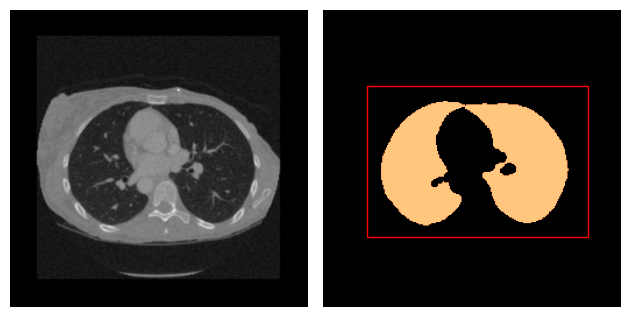

In [27]:
example = train_dataset[50]
for k,v in example.items():
    print(k,v.shape)

xmin, ymin, xmax, ymax = get_bounding_box(example['ground_truth_mask'])

fig, axs = plt.subplots(1, 2)

axs[0].imshow(example['pixel_values'][1], cmap='gray')
axs[0].axis('off')

axs[1].imshow(example['ground_truth_mask'], cmap='copper')

# create a Rectangle patch for the bounding box
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

# add the patch to the second Axes
axs[1].add_patch(rect)

axs[1].axis('off')

plt.tight_layout()
plt.show()

In order to finetune the model, we freeze the encoder weights from the pre-trained SAM model:

In [28]:
# load the pretrained weights for finetuning
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder (encoder weights are frozen)
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        print(name)
        param.requires_grad_(False)   

c:\Users\earth\anaconda3\envs\monai2\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\earth\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vision_encoder.pos_embed
vision_encoder.patch_embed.projection.weight
vision_encoder.patch_embed.projection.bias
vision_encoder.layers.0.layer_norm1.weight
vision_encoder.layers.0.layer_norm1.bias
vision_encoder.layers.0.attn.rel_pos_h
vision_encoder.layers.0.attn.rel_pos_w
vision_encoder.layers.0.attn.qkv.weight
vision_encoder.layers.0.attn.qkv.bias
vision_encoder.layers.0.attn.proj.weight
vision_encoder.layers.0.attn.proj.bias
vision_encoder.layers.0.layer_norm2.weight
vision_encoder.layers.0.layer_norm2.bias
vision_encoder.layers.0.mlp.lin1.weight
vision_encoder.layers.0.mlp.lin1.bias
vision_encoder.layers.0.mlp.lin2.weight
vision_encoder.layers.0.mlp.lin2.bias
vision_encoder.layers.1.layer_norm1.weight
vision_encoder.layers.1.layer_norm1.bias
vision_encoder.layers.1.attn.rel_pos_h
vision_encoder.layers.1.attn.rel_pos_w
vision_encoder.layers.1.attn.qkv.weight
vision_encoder.layers.1.attn.qkv.bias
vision_encoder.layers.1.attn.proj.weight
vision_encoder.layers.1.attn.proj.bias
vision_

**Train Model**

In [17]:
# define training loop
num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# define optimizer
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# define segmentation loss with sigmoid activation applied to predictions from the model
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# track mean train and validation losses
mean_train_losses, mean_val_losses = [], []

# create an artibarily large starting validation loss value
best_val_loss = 100.0
best_val_epoch = 0

# set model to train mode for gradient updating
model.train()
for epoch in range(num_epochs):
    
    # create temporary list to record training losses
    epoch_losses = []
    for i, batch in enumerate(tqdm(train_dataloader)):

        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())
        
        # visualize training predictions every 50 iterations
        if i % 50 == 0:
            
            # clear jupyter cell output
            clear_output(wait=True)
            
            fig, axs = plt.subplots(1, 3)
            xmin, ymin, xmax, ymax = get_bounding_box(batch['ground_truth_mask'][0])
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

            axs[0].set_title('input image')
            axs[0].imshow(batch["pixel_values"][0,1], cmap='gray')
            axs[0].axis('off')

            axs[1].set_title('ground truth mask')
            axs[1].imshow(batch['ground_truth_mask'][0], cmap='copper')
            axs[1].add_patch(rect)
            axs[1].axis('off')
            
            # apply sigmoid
            medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
            
            # convert soft mask to hard mask
            medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
            medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

            axs[2].set_title('predicted mask')
            axs[2].imshow(medsam_seg, cmap='copper')
            axs[2].axis('off')

            plt.tight_layout()
            plt.show()
    
    # create temporary list to record validation losses
    val_losses = []
    
    # set model to eval mode for validation
    with torch.no_grad():
        for val_batch in tqdm(val_dataloader):
            
            # forward pass
            outputs = model(pixel_values=val_batch["pixel_values"].to(device),
                      input_boxes=val_batch["input_boxes"].to(device),
                      multimask_output=False)
            
            # calculate val loss
            predicted_val_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            val_loss = seg_loss(predicted_val_masks, ground_truth_masks.unsqueeze(1))

            val_losses.append(val_loss.item())
        
        # visualize the last validation prediction
        fig, axs = plt.subplots(1, 3)
        xmin, ymin, xmax, ymax = get_bounding_box(val_batch['ground_truth_mask'][0])
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

        axs[0].set_title('input image')
        axs[0].imshow(val_batch["pixel_values"][0,1], cmap='gray')
        axs[0].axis('off')

        axs[1].set_title('ground truth mask')
        axs[1].imshow(val_batch['ground_truth_mask'][0], cmap='copper')
        axs[1].add_patch(rect)
        axs[1].axis('off')

        # apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        axs[2].set_title('predicted mask')
        axs[2].imshow(medsam_seg, cmap='copper')
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

        # save the best weights and record the best performing epoch
        if mean(val_losses) < best_val_loss:
            torch.save(model.state_dict(), f"best_weights.pth")
            print(f"Model Was Saved! Current Best val loss {best_val_loss}")
            best_val_loss = mean(val_losses)
            best_val_epoch = epoch
        else:
            print("Model Was Not Saved!")
    
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    
    mean_train_losses.append(mean(epoch_losses))
    mean_val_losses.append(mean(val_losses))

NameError: name 'model' is not defined

**Inference**

In [ ]:
# create test dataloader
test_dataset = SAMDataset(image_paths=data_paths['test_images'], mask_paths=data_paths['test_masks'], processor=processor)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

  0%|          | 0/49 [00:00<?, ?it/s]

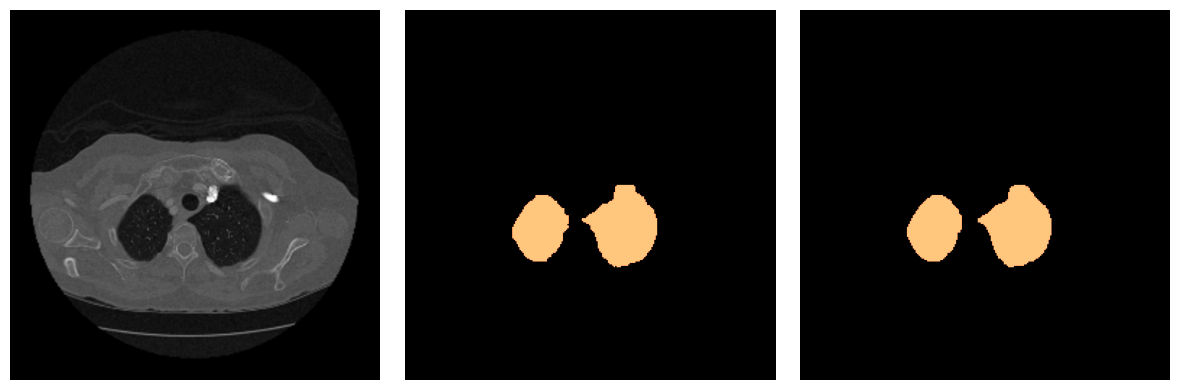

  2%|▏         | 1/49 [00:01<00:51,  1.08s/it]

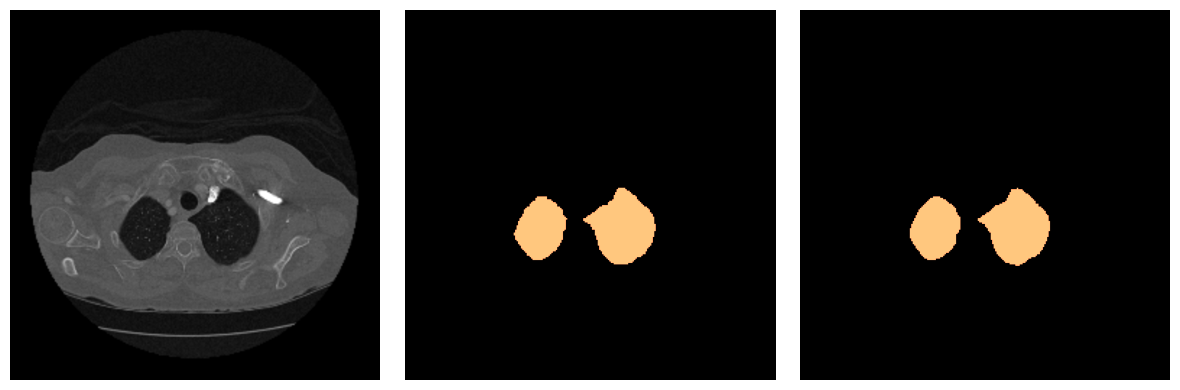

  4%|▍         | 2/49 [00:02<00:51,  1.10s/it]

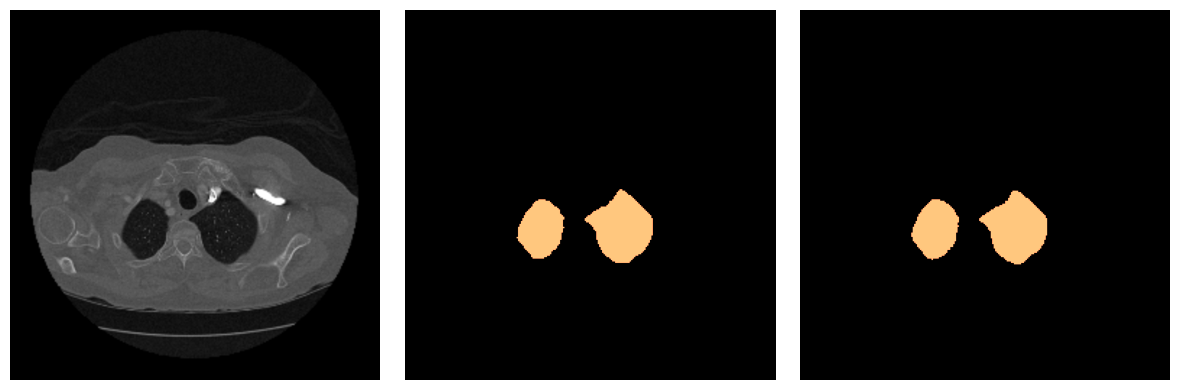

  6%|▌         | 3/49 [00:03<00:46,  1.02s/it]

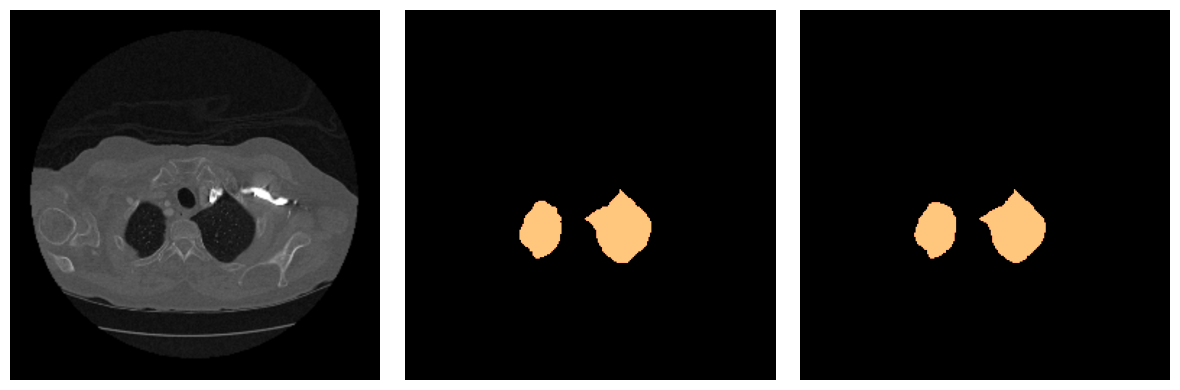

  8%|▊         | 4/49 [00:03<00:42,  1.07it/s]

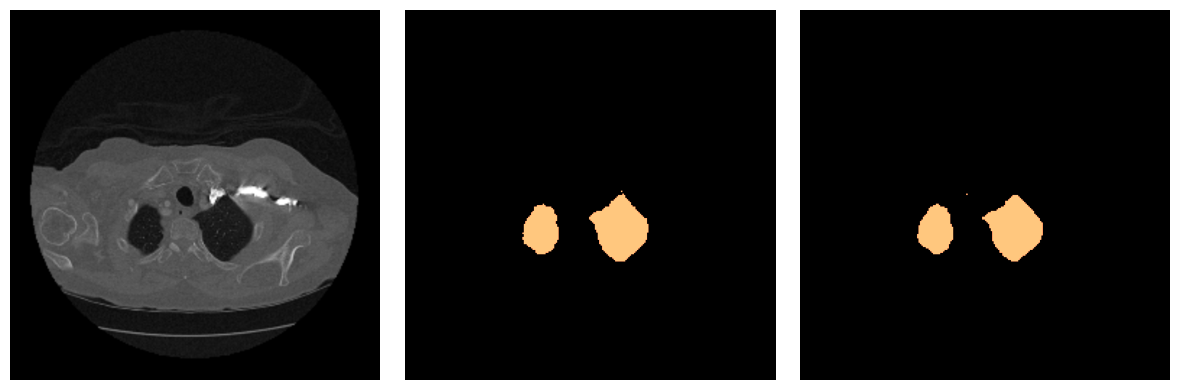

 10%|█         | 5/49 [00:04<00:39,  1.12it/s]

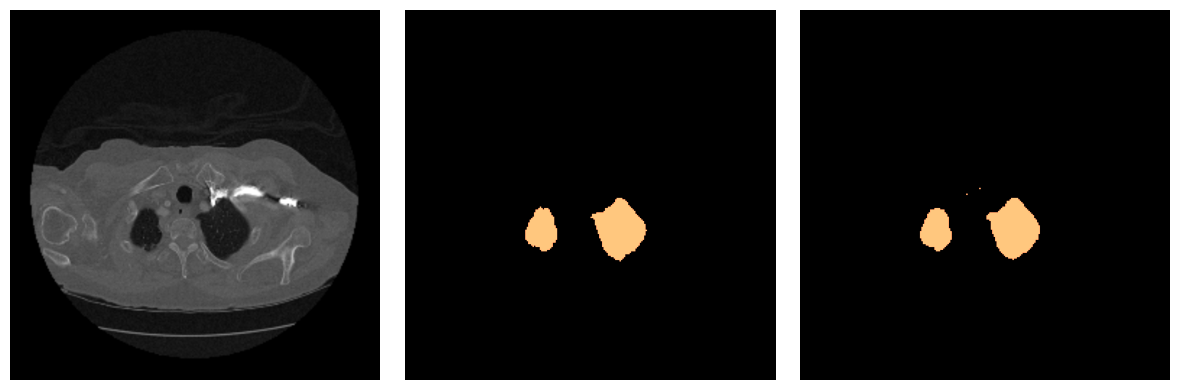

 12%|█▏        | 6/49 [00:05<00:39,  1.09it/s]

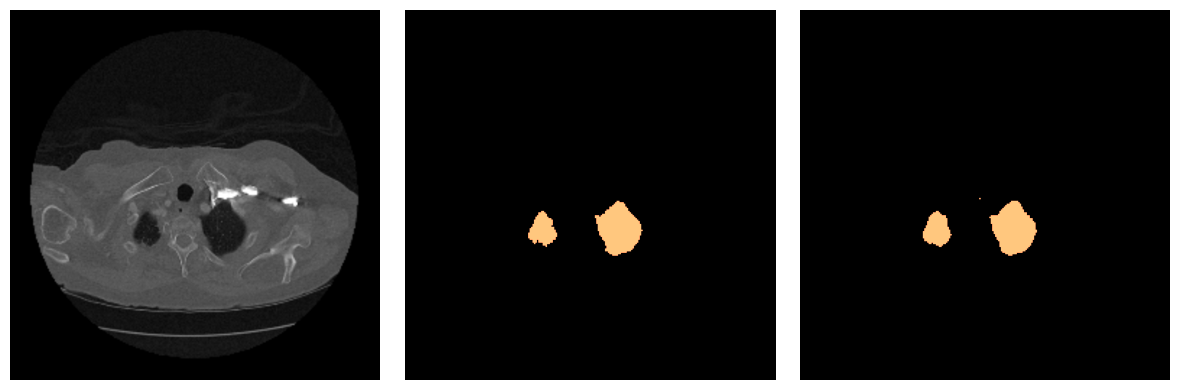

 14%|█▍        | 7/49 [00:06<00:40,  1.04it/s]

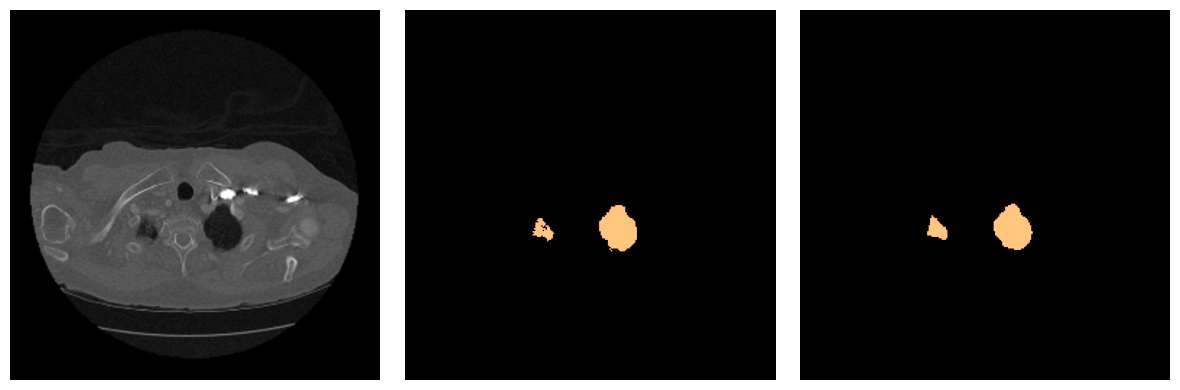

 16%|█▋        | 8/49 [00:07<00:39,  1.04it/s]

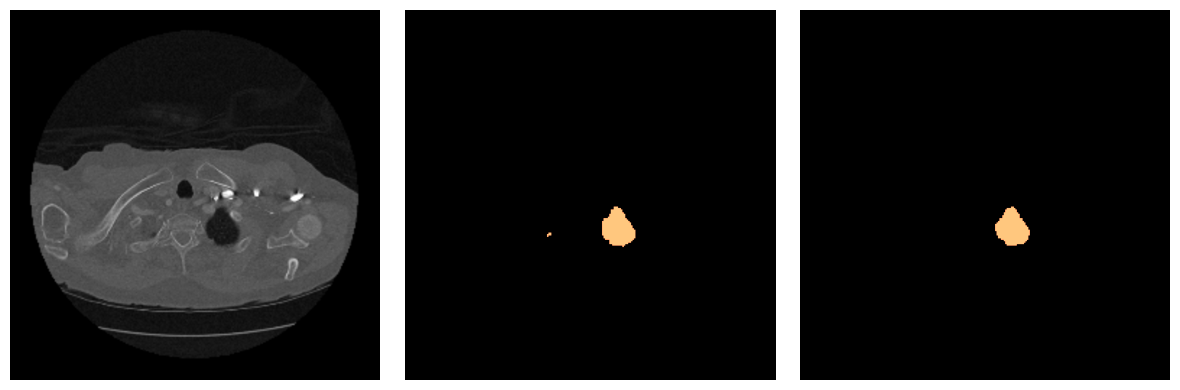

 18%|█▊        | 9/49 [00:08<00:38,  1.04it/s]

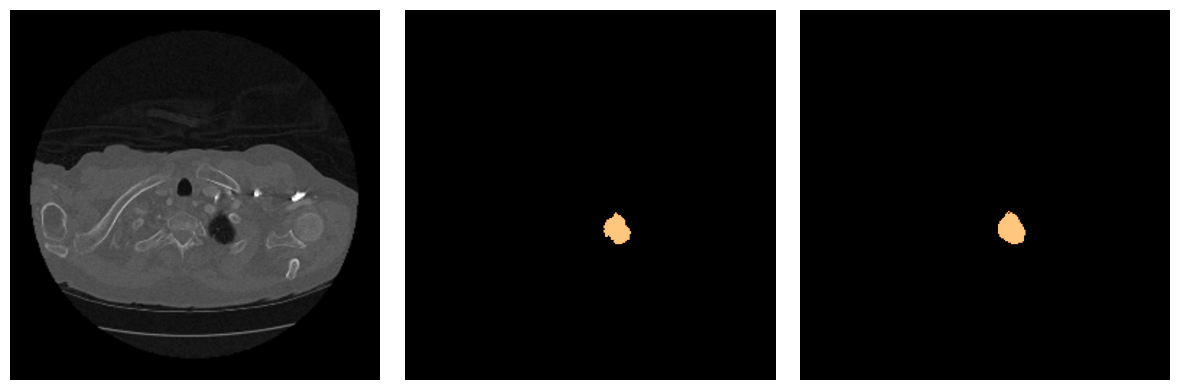

 20%|██        | 10/49 [00:09<00:37,  1.04it/s]

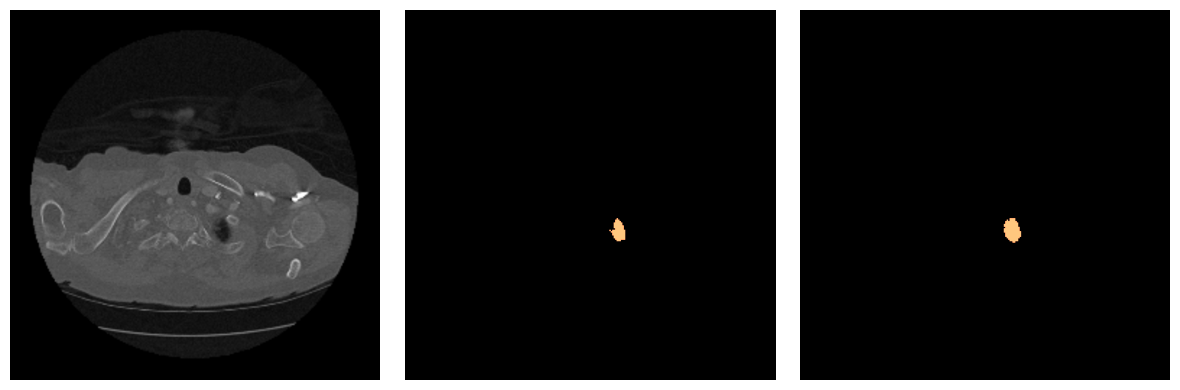

 22%|██▏       | 11/49 [00:10<00:34,  1.09it/s]

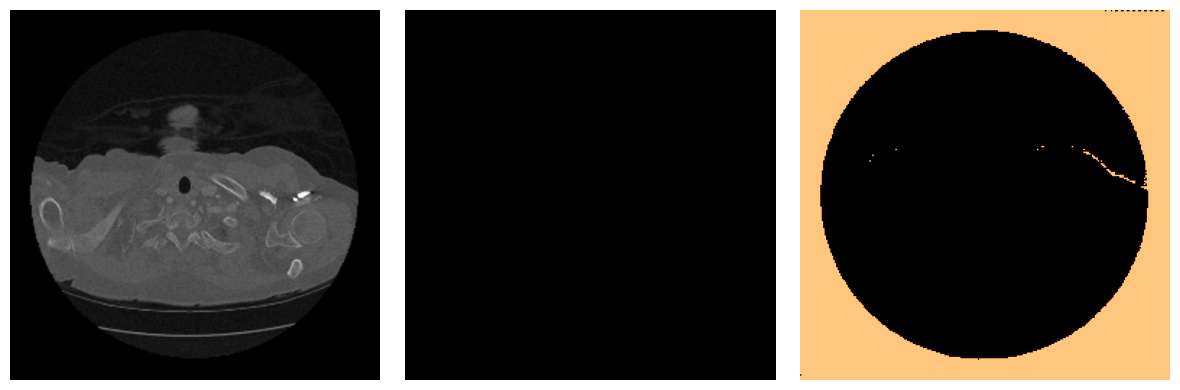

 24%|██▍       | 12/49 [00:11<00:32,  1.13it/s]

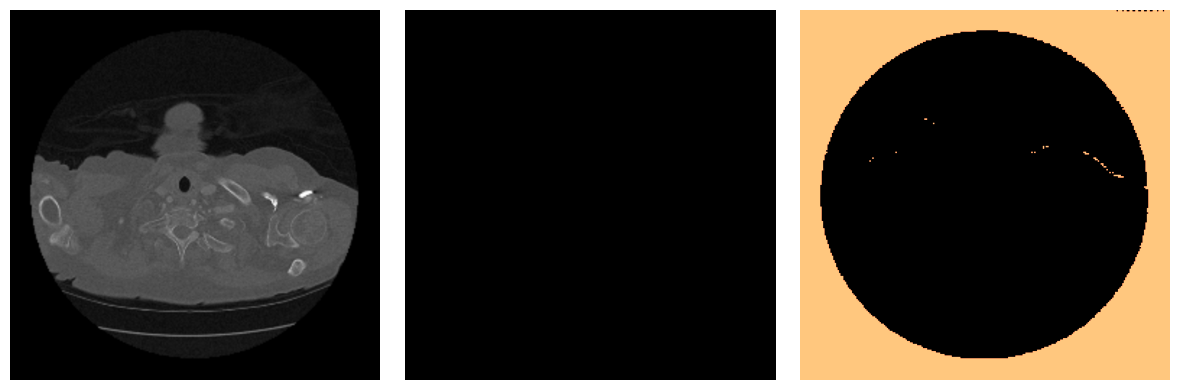

 27%|██▋       | 13/49 [00:12<00:32,  1.12it/s]

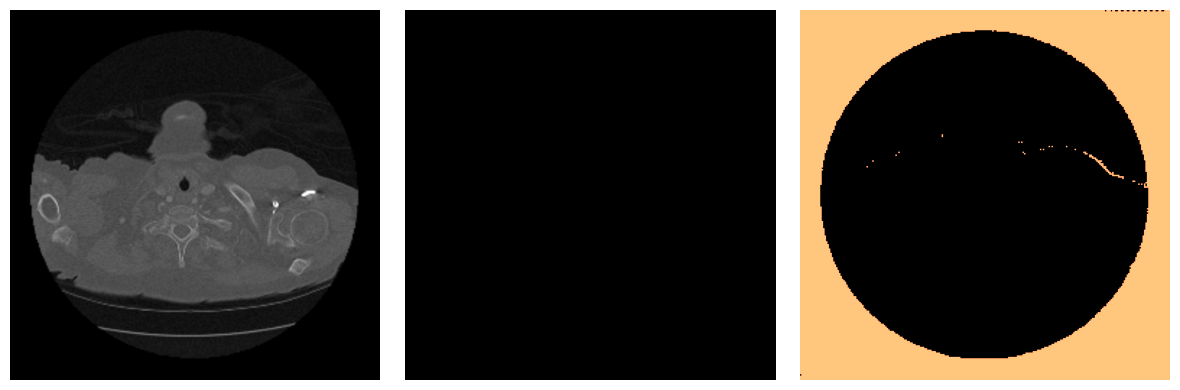

 29%|██▊       | 14/49 [00:12<00:30,  1.15it/s]

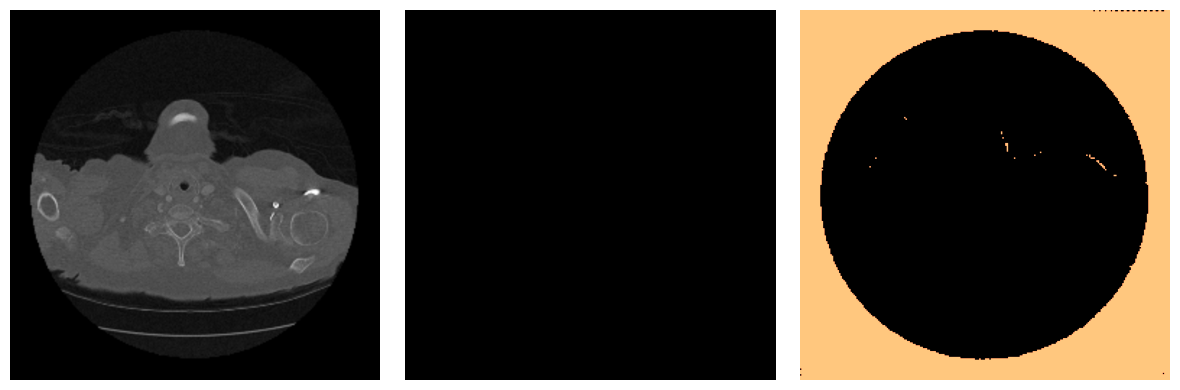

 31%|███       | 15/49 [00:13<00:29,  1.15it/s]

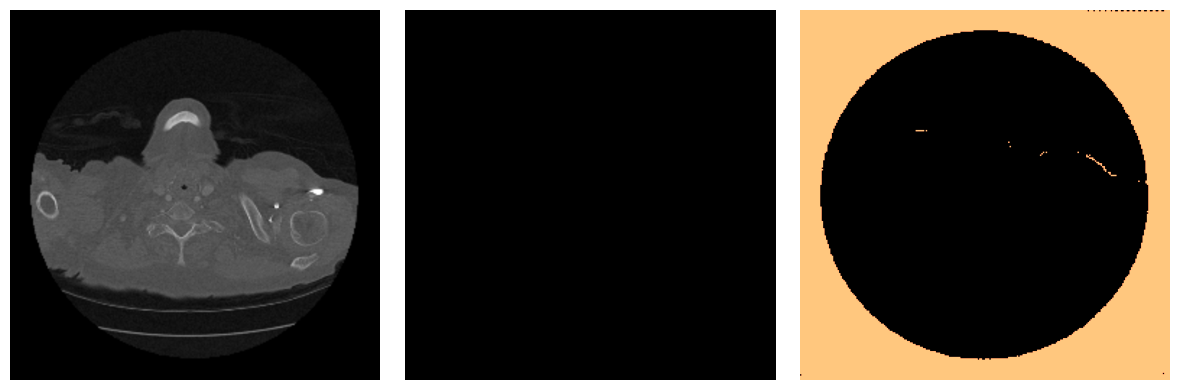

 33%|███▎      | 16/49 [00:14<00:28,  1.16it/s]

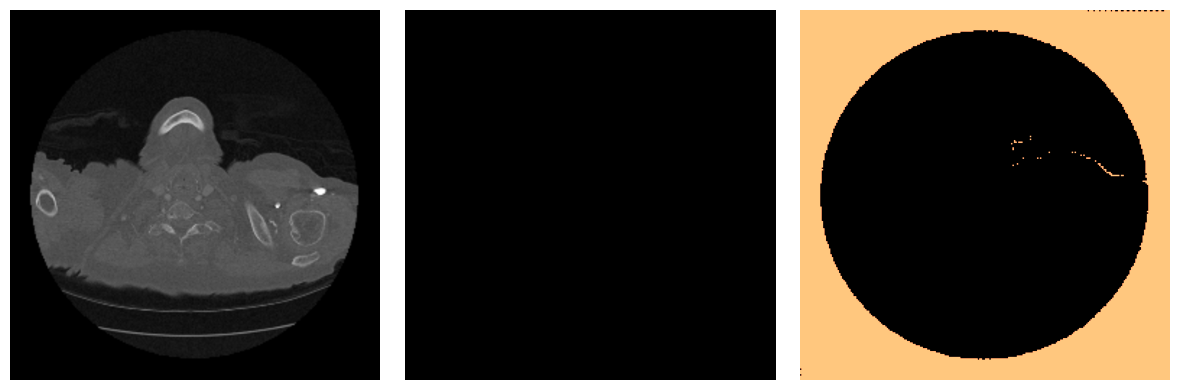

 35%|███▍      | 17/49 [00:15<00:27,  1.17it/s]

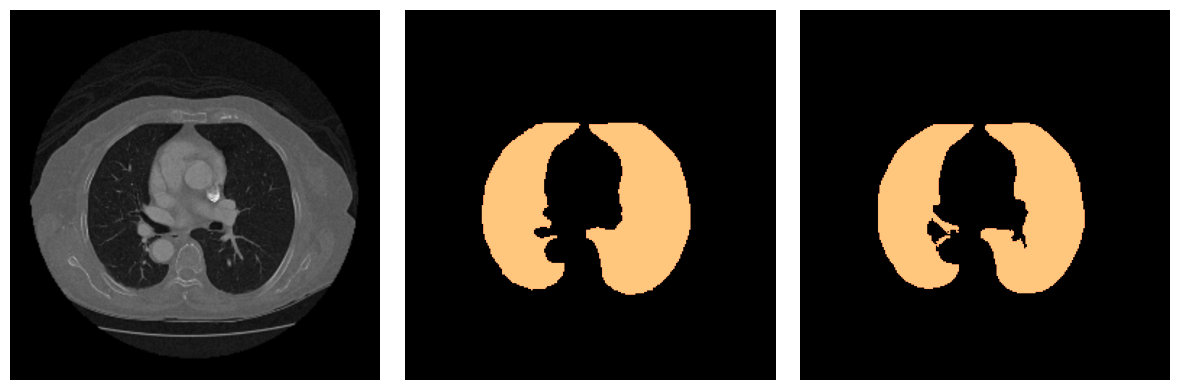

 37%|███▋      | 18/49 [00:16<00:26,  1.17it/s]

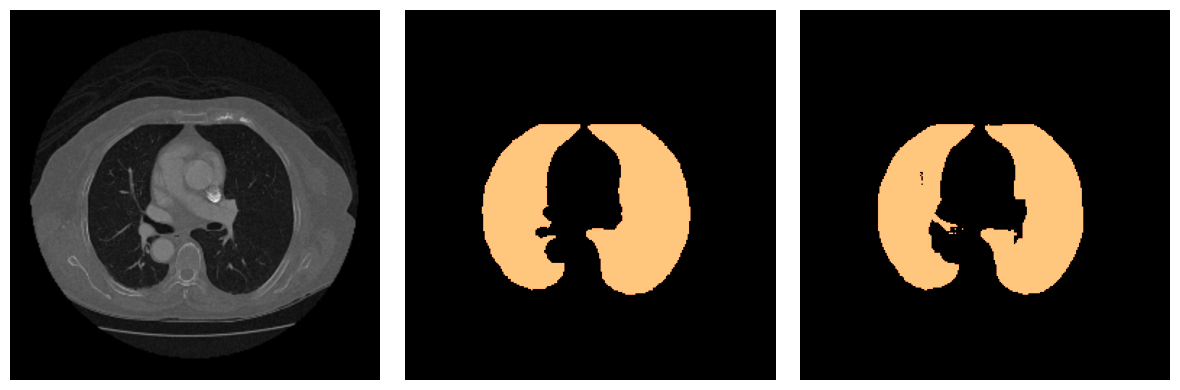

 39%|███▉      | 19/49 [00:17<00:25,  1.19it/s]

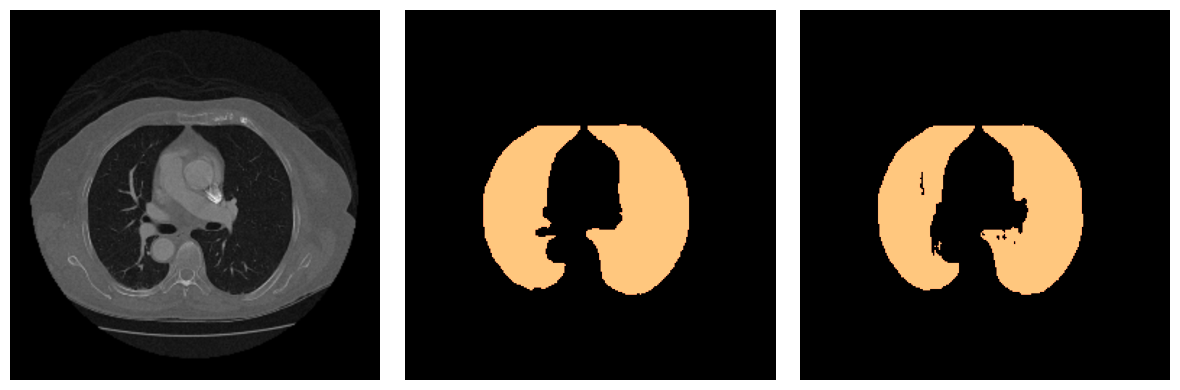

 41%|████      | 20/49 [00:18<00:24,  1.19it/s]

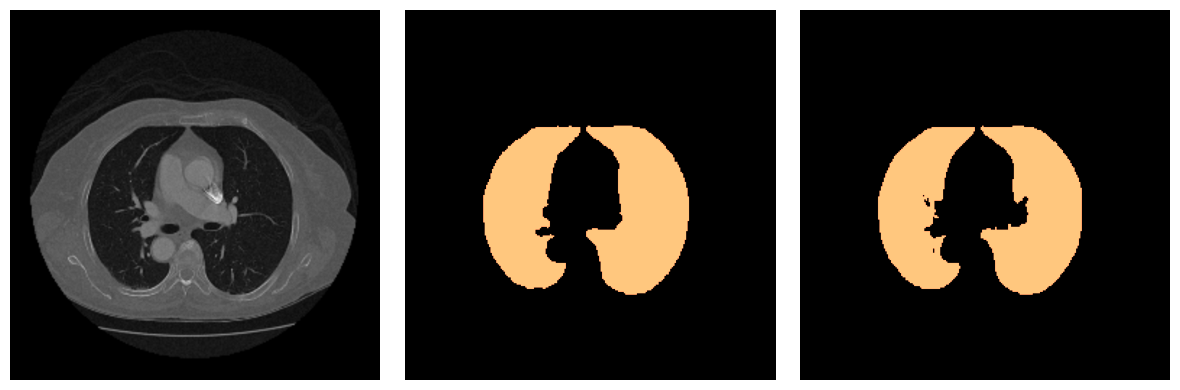

 43%|████▎     | 21/49 [00:19<00:26,  1.04it/s]

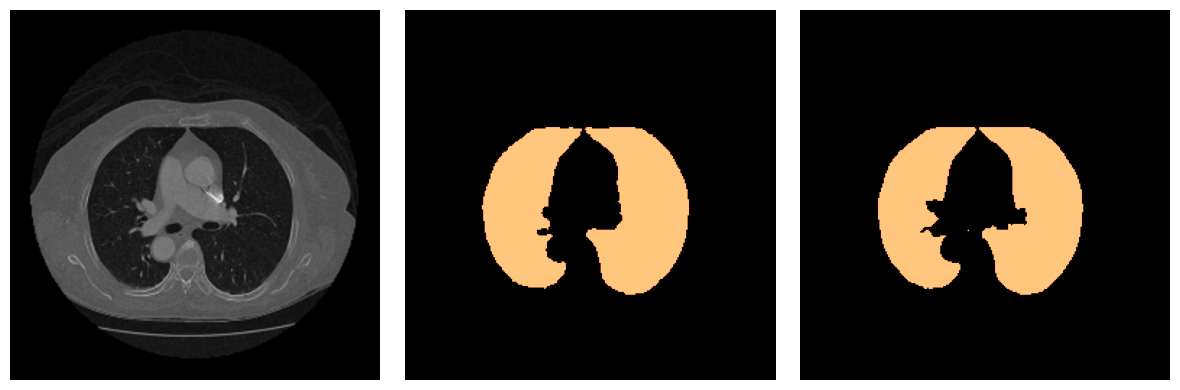

 45%|████▍     | 22/49 [00:20<00:26,  1.02it/s]

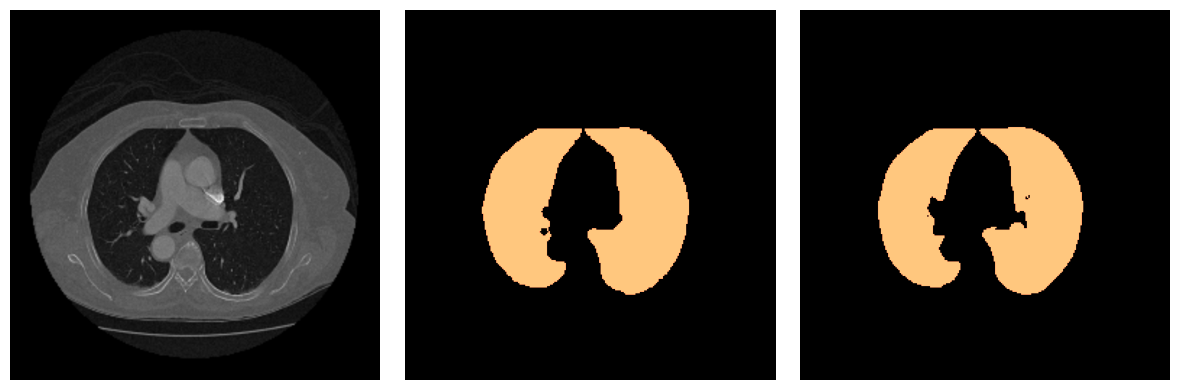

 47%|████▋     | 23/49 [00:21<00:25,  1.00it/s]

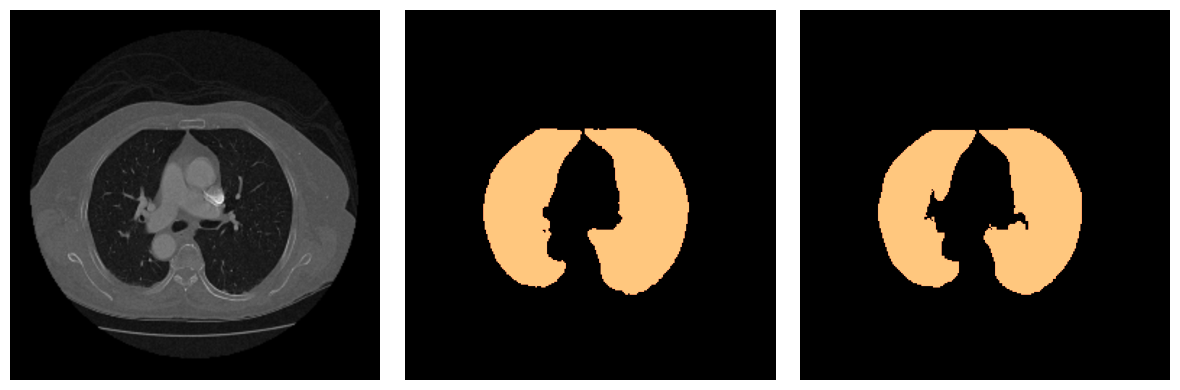

 49%|████▉     | 24/49 [00:22<00:24,  1.00it/s]

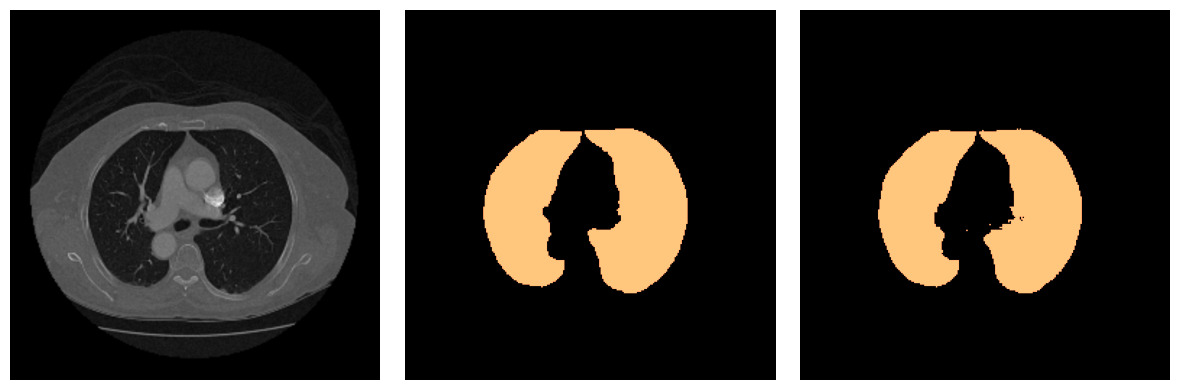

 51%|█████     | 25/49 [00:23<00:24,  1.01s/it]

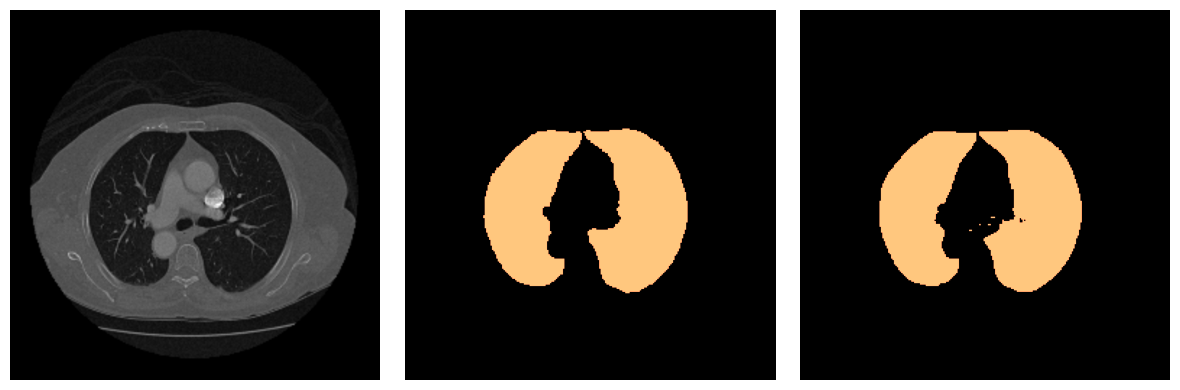

 53%|█████▎    | 26/49 [00:24<00:22,  1.02it/s]

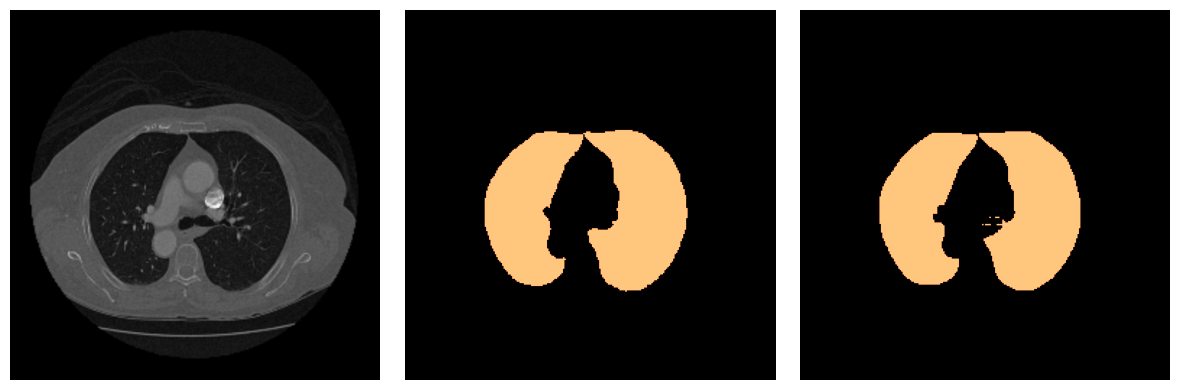

 55%|█████▌    | 27/49 [00:25<00:20,  1.05it/s]

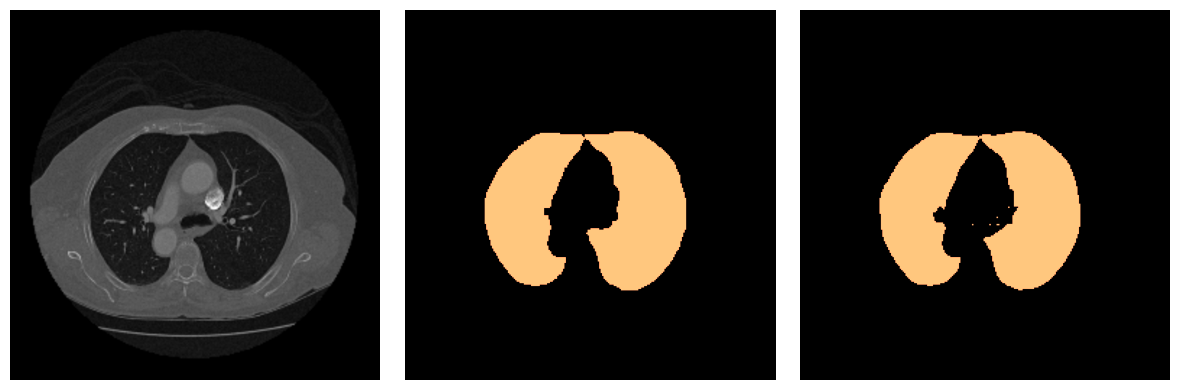

 57%|█████▋    | 28/49 [00:26<00:19,  1.09it/s]

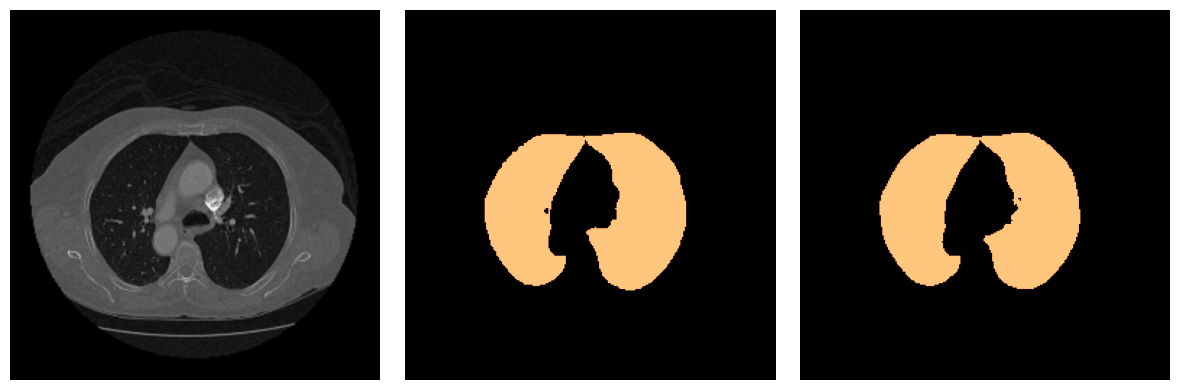

 59%|█████▉    | 29/49 [00:26<00:17,  1.12it/s]

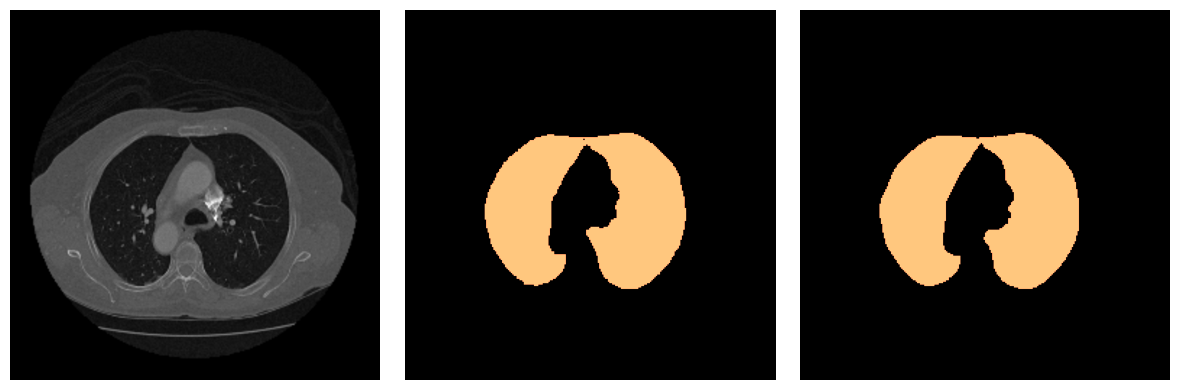

 61%|██████    | 30/49 [00:27<00:16,  1.14it/s]

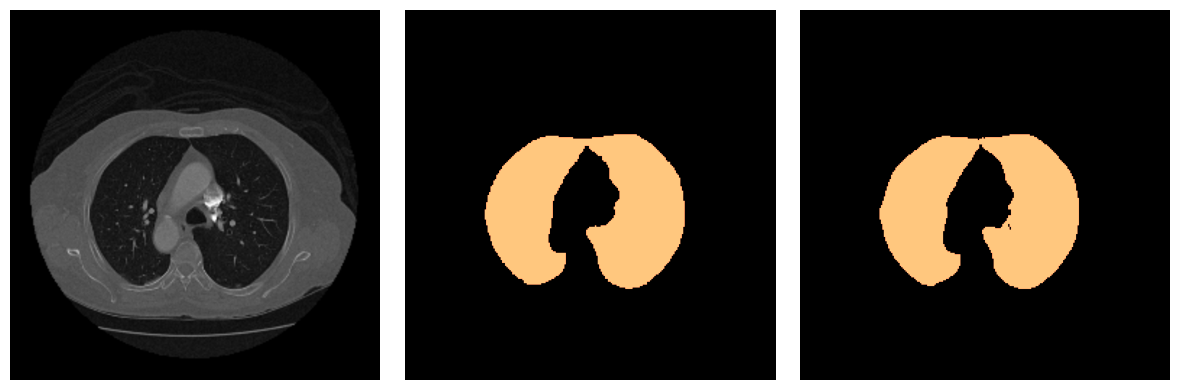

 63%|██████▎   | 31/49 [00:28<00:15,  1.14it/s]

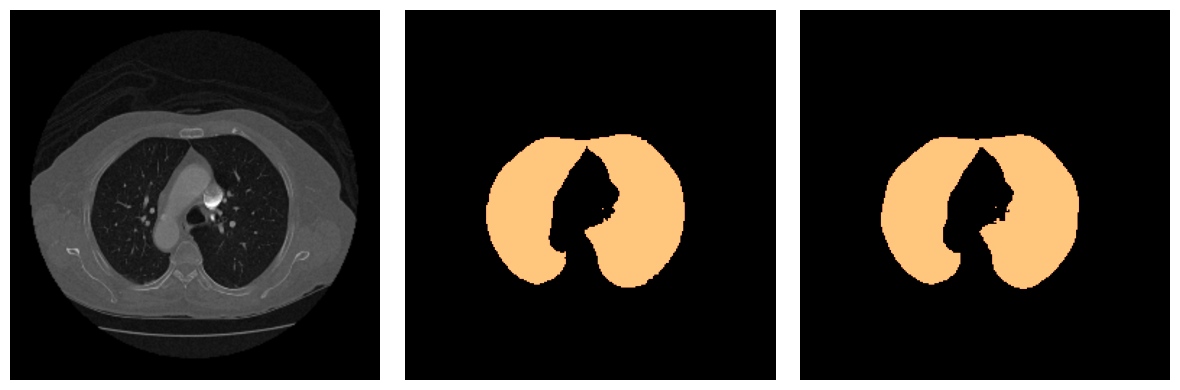

 65%|██████▌   | 32/49 [00:29<00:14,  1.15it/s]

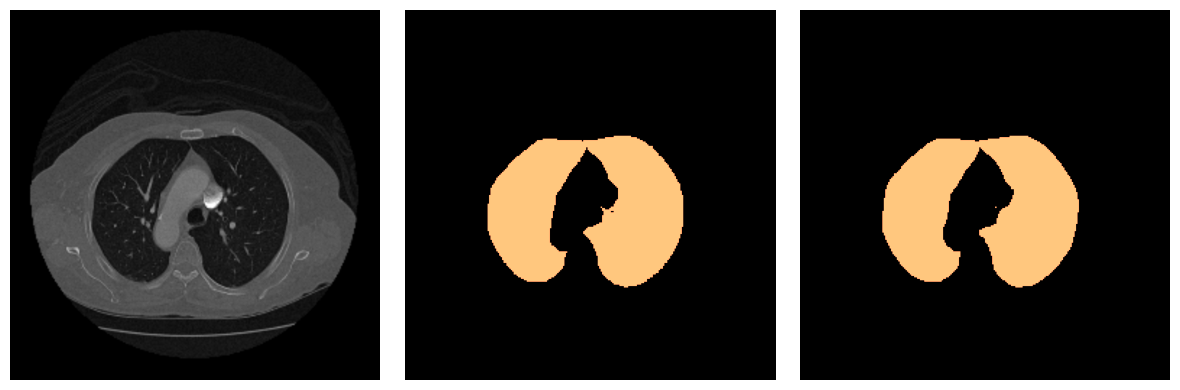

 67%|██████▋   | 33/49 [00:30<00:13,  1.16it/s]

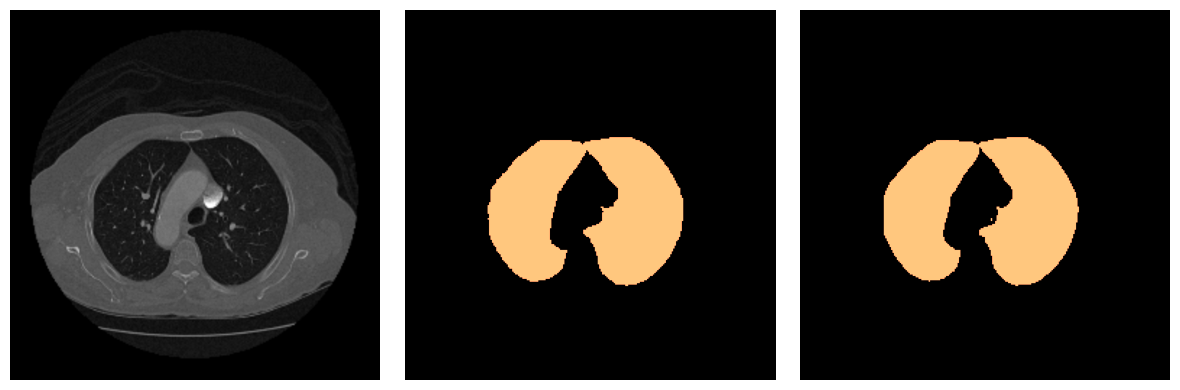

 69%|██████▉   | 34/49 [00:31<00:13,  1.15it/s]

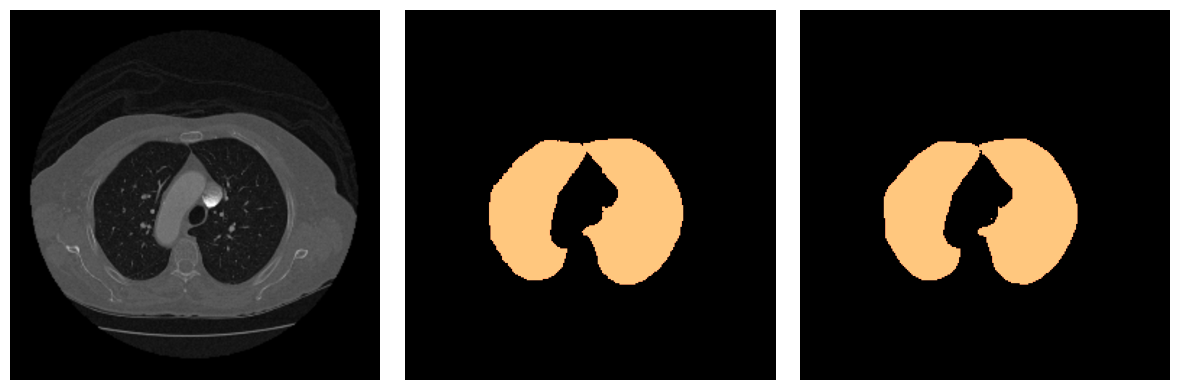

 71%|███████▏  | 35/49 [00:32<00:12,  1.15it/s]

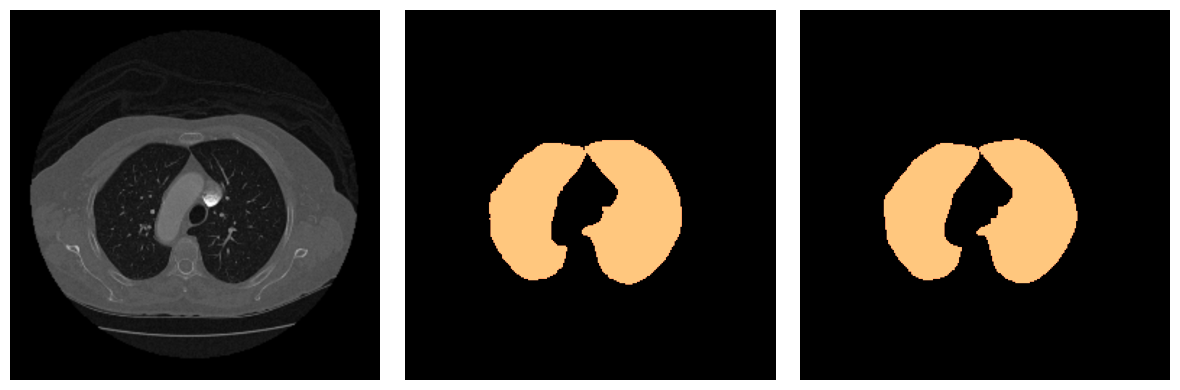

 73%|███████▎  | 36/49 [00:32<00:11,  1.15it/s]

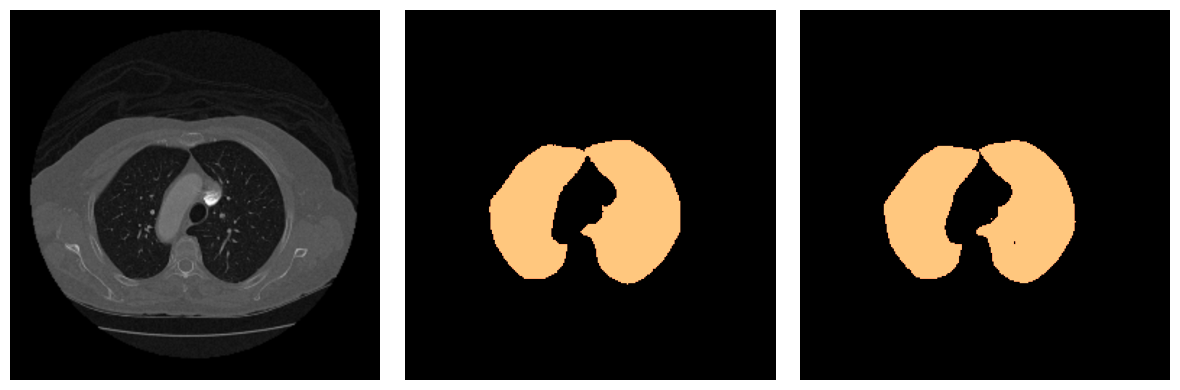

 76%|███████▌  | 37/49 [00:33<00:10,  1.14it/s]

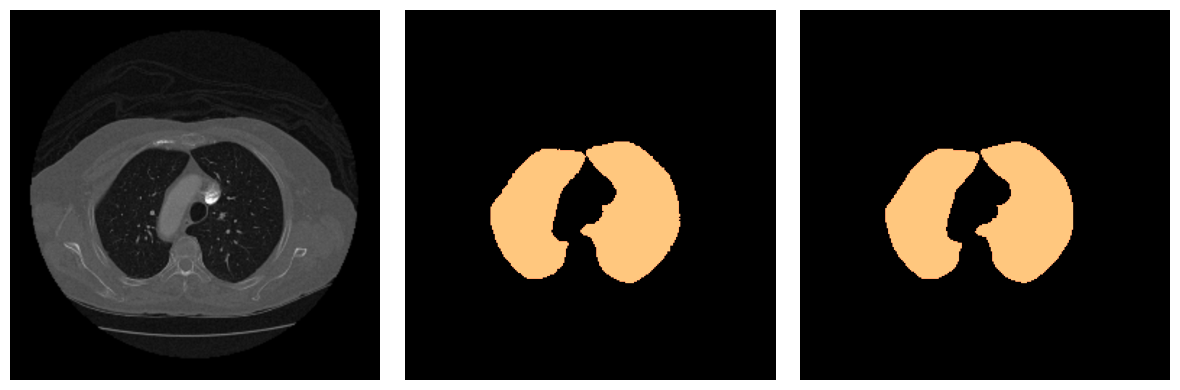

 78%|███████▊  | 38/49 [00:34<00:10,  1.08it/s]

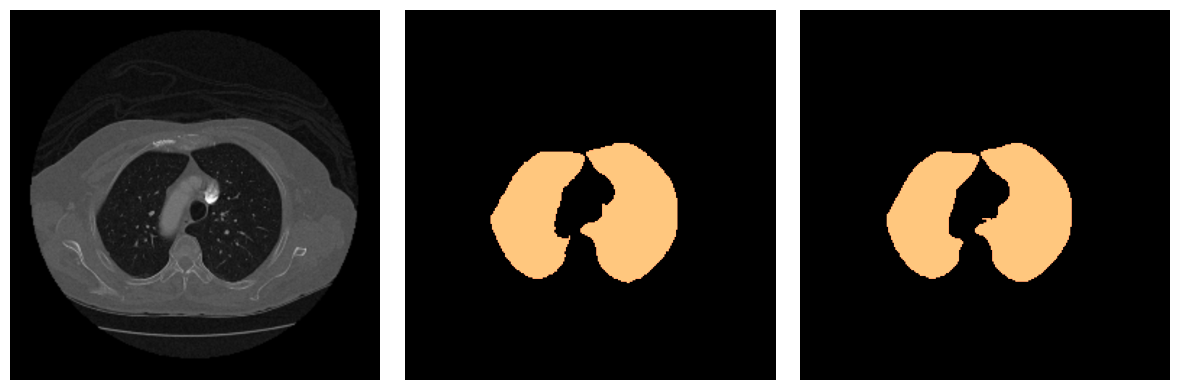

 80%|███████▉  | 39/49 [00:35<00:09,  1.03it/s]

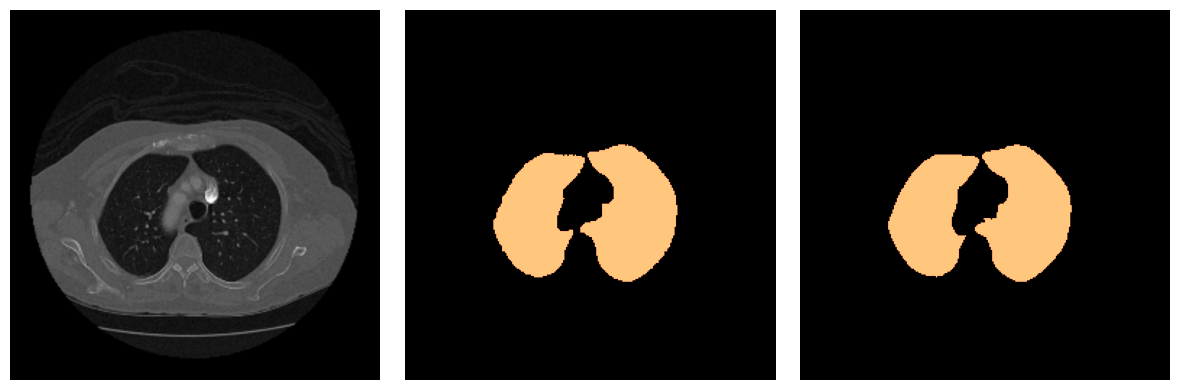

 82%|████████▏ | 40/49 [00:36<00:09,  1.01s/it]

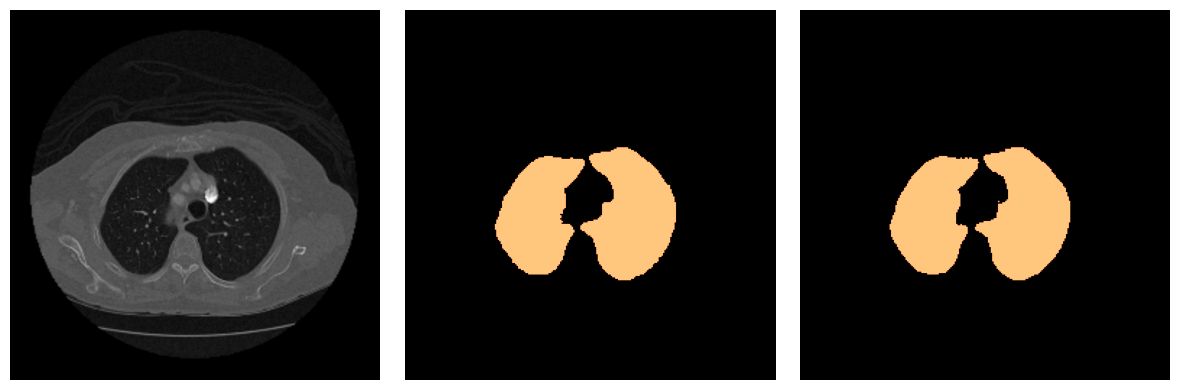

 84%|████████▎ | 41/49 [00:37<00:07,  1.00it/s]

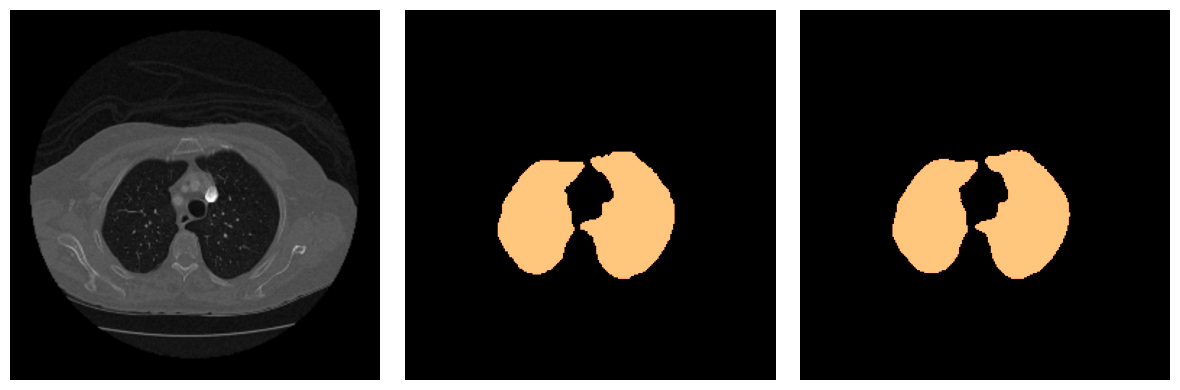

 86%|████████▌ | 42/49 [00:38<00:06,  1.03it/s]

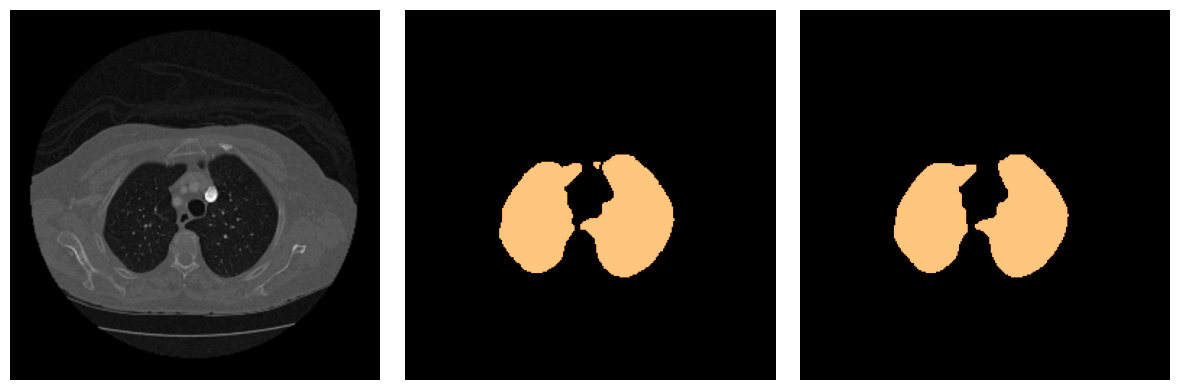

 88%|████████▊ | 43/49 [00:39<00:05,  1.06it/s]

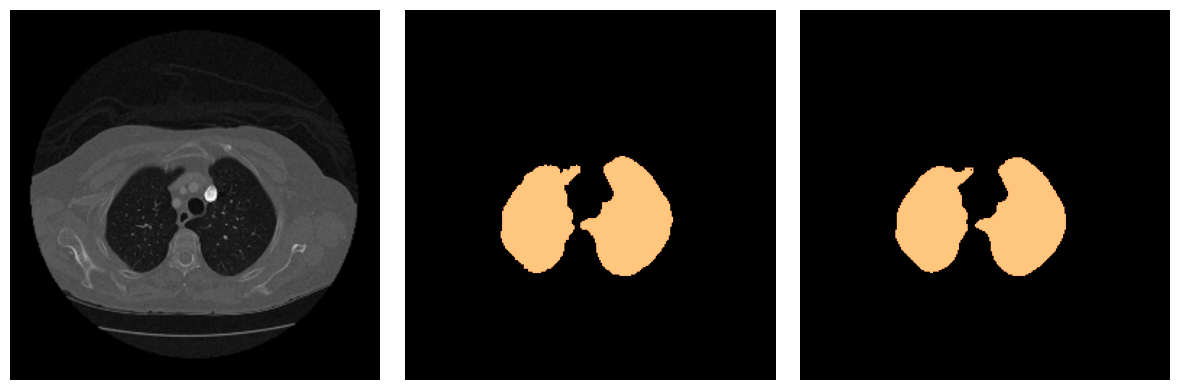

 90%|████████▉ | 44/49 [00:40<00:04,  1.08it/s]

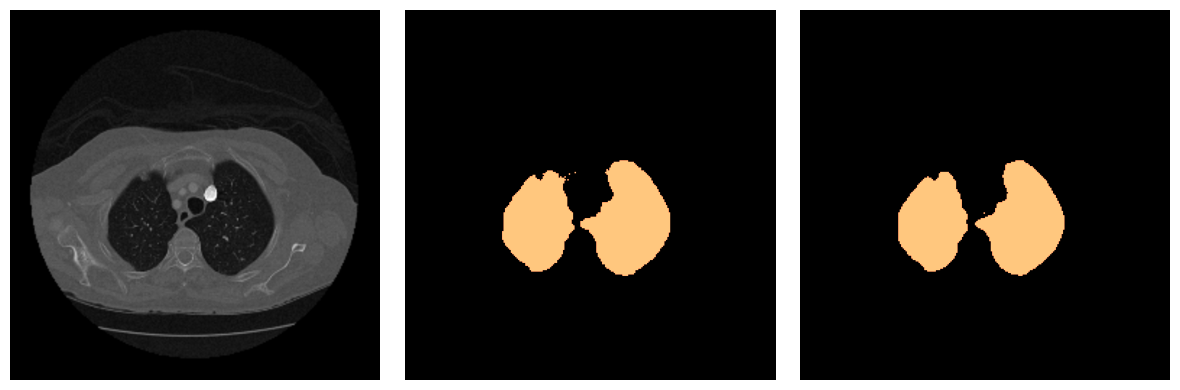

 92%|█████████▏| 45/49 [00:41<00:03,  1.09it/s]

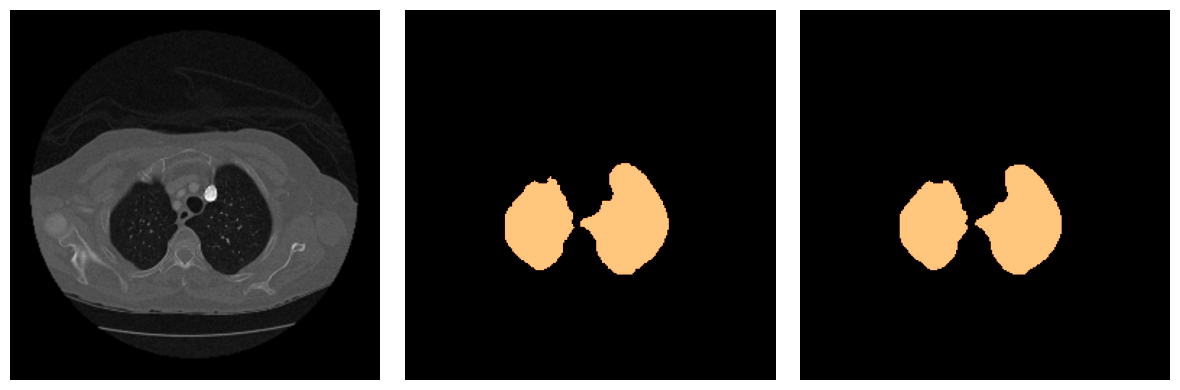

 94%|█████████▍| 46/49 [00:42<00:02,  1.13it/s]

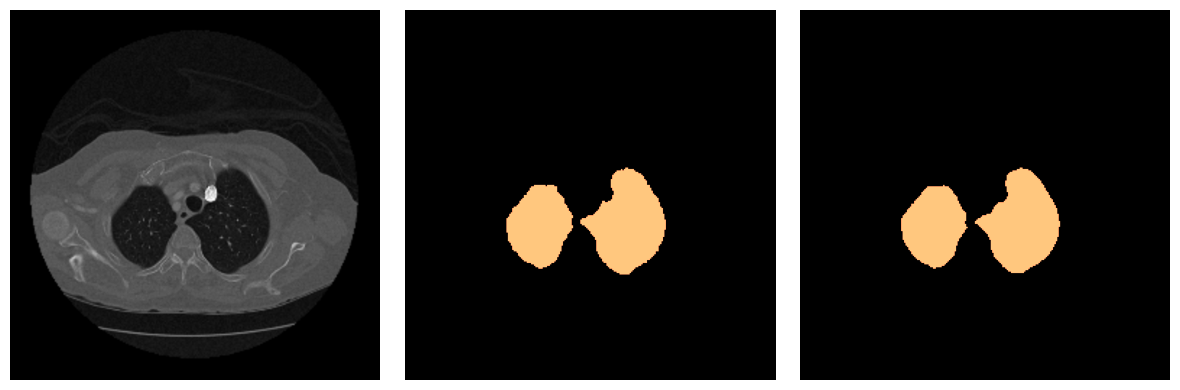

 96%|█████████▌| 47/49 [00:43<00:01,  1.14it/s]

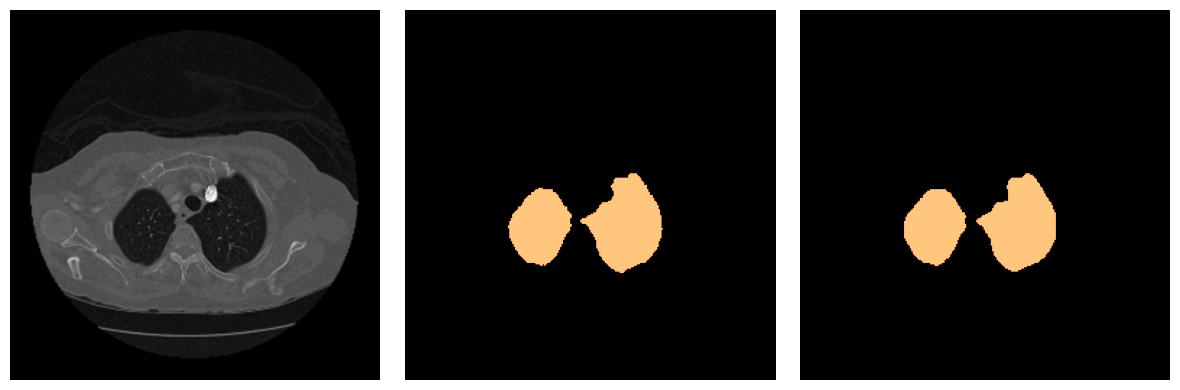

 98%|█████████▊| 48/49 [00:44<00:00,  1.13it/s]

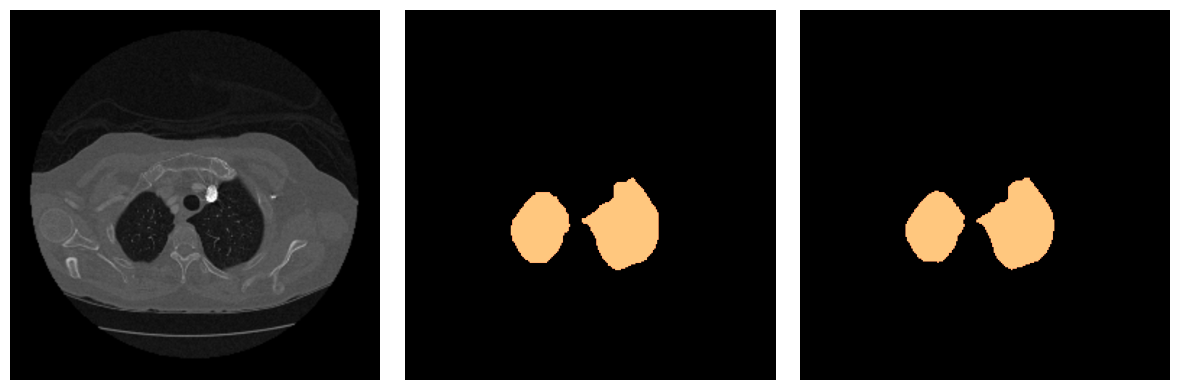

100%|██████████| 49/49 [00:44<00:00,  1.09it/s]


In [ ]:
# Iteratire through test images
with torch.no_grad():
    for batch in tqdm(test_dataloader):

        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].cuda(),
                      input_boxes=batch["input_boxes"].cuda(),
                      multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().cuda()
#         loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        

        # apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
        
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(batch["pixel_values"][0,1], cmap='gray')
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(batch["ground_truth_mask"][0], cmap='copper')
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(medsam_seg, cmap='copper')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    #     outputs = model(**inputs, multimask_output=False)

Congratulations! You have now successfully finetuned the SAM model to segment the lungs from CT scans using bounding box prompts. Happy coding!